<a href="https://colab.research.google.com/github/neemasingh/neema/blob/master/stock_price_prediction_using_GRU/ATSA_Arima_GRU_NIFTY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA


In [0]:
variables = pd.read_csv("/content/ICICIBANK.NS.csv")
Close =variables ["Close"]
Close

0      159.945007
1      161.464005
2      162.699997
3      161.164001
4      158.899994
          ...    
234    200.800003
235    192.417999
236    203.108994
237    203.709000
238    203.544998
Name: Close, Length: 239, dtype: float64

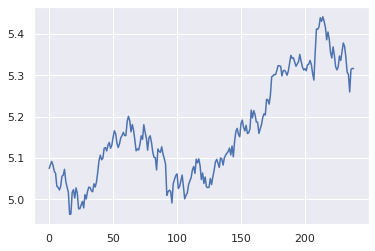

In [0]:
lnClose=np.log(Close)
lnClose
plt.plot(lnClose)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


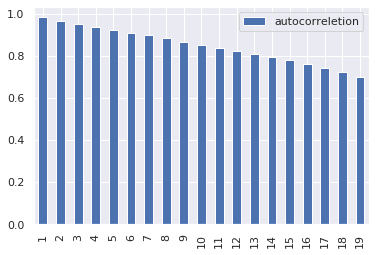

In [0]:
acf_1 =  acf(lnClose)[1:20]
test_df = pd.DataFrame([acf_1]).T
test_df.columns = ['autocorreletion']
test_df.index += 1
test_df.plot(kind='bar')
plt.show()


<function matplotlib.pyplot.show>

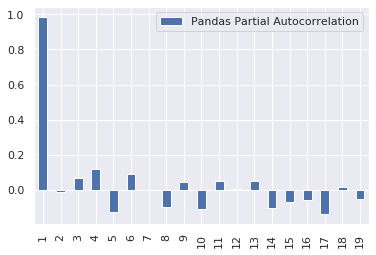

In [0]:
pacf_1 = pacf(lnClose)[1:20]
test_df = pd.DataFrame([pacf_1]).T
test_df.columns = ['Pandas Partial Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')
plt.show


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


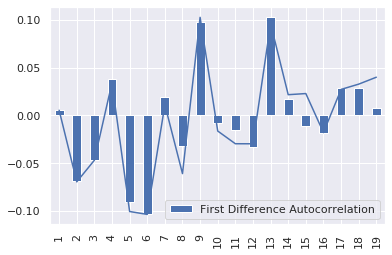

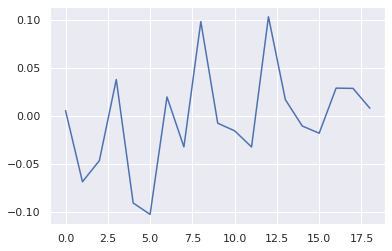

In [0]:
lnClose_diff=lnClose-lnClose.shift(1)
diff=lnClose_diff.dropna()
acf_1_diff =  acf(diff)[1:20]
test_df = pd.DataFrame([acf_1_diff]).T
test_df.columns = ['First Difference Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')
pacf_1_diff =  pacf(diff)[1:20]
plt.plot(pacf_1_diff)
plt.show()
plt.plot(acf_1_diff)
plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


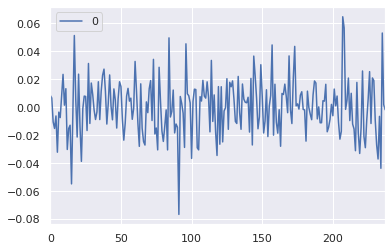

            0
0    0.008439
1    0.006613
2   -0.010498
3   -0.015160
4   -0.006231
..        ...
233 -0.006521
234 -0.043652
235  0.053060
236  0.001937
237 -0.001818

[238 rows x 1 columns]


In [0]:
price_matrix=lnClose.as_matrix()
model = ARIMA(price_matrix, order=(0,1,0))
model_fit = model.fit(disp=0)
from pandas import DataFrame
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
res = residuals.describe()
print(residuals)

In [0]:
predictions=model_fit.predict(1, 238, typ='levels')
# print(predictions)
predictionsadjusted=np.exp(predictions)
# print(predictionsadjusted)

tmp = []
residuals = [];

predictions = [np.mean(predictions)] + predictions
        
residual = pd.Series(np.array(predictionsadjusted) - np.array(predictions))
# print("resi")
# print(residual)
tmp.append(np.array(residual))

residuals.append(tmp[0][:238])
print("Fitted data: ")
print(residuals[0][:20])

residuals = pd.DataFrame(residuals)

import csv

np.savetxt("/content/residuals.csv", residuals, delimiter='\n', header="Residuals", comments="")


Fitted data: 
[149.86747285 151.37855795 152.60817669 151.08010969 148.82795589
 148.00533995 143.18557265 142.80567772 141.83907242 143.13186941
 146.91121734 147.30011684 149.55113281 144.984659   142.81561745
 141.02563618 133.16141737 133.29759362 140.94411    141.92956961]


In [0]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [0]:
df = pd.read_csv('/content/residuals.csv')
df.head()

,Residuals
0,149.867473
1,151.378558
2,152.608177
3,151.080110
4,148.827956


In [0]:
minmax = MinMaxScaler().fit(df.iloc[:, 0:1].astype('float32')) # Residual index
df_log = minmax.transform(df.iloc[:, 0:1].astype('float32')) # Residual index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.191536
1,0.208861
2,0.222959
3,0.205439
4,0.179618


In [0]:
test_size = 20
simulation_size = 1

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((238, 1), (218, 1), (20, 1))

In [0]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

from sklearn.metrics import mean_squared_error

def calculate_accuracy(real, predict):
        real = np.array(real) + 1
        predict = np.array(predict) + 1
        #error = mean_squared_error(real, predict)
        percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
        return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [0]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 50
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [0]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [0]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i+1))
    results.append(forecast())

simulation 1


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 50/50 [00:09<00:00,  5.53it/s, acc=97, cost=0.00175]


In [0]:
#accuracies = [calculate_accuracy(df['Residuals'].iloc[-test_size:].values, r) for r in results]

accuracies = [calculate_accuracy(variables ["Close"].iloc[-test_size:].values, r) for r in results]

#plt.figure(figsize = (15, 5))
#for no, r in enumerate(results):
    #plt.plot(r, label = 'forecast %d'%(no + 1))
    
#plt.plot(df['Residuals'].iloc[-test_size:].values, label = 'true trend', c = 'black')
#plt.legend()
print("Accuracy : ", np.mean(accuracies), " %")
#plt.show()

Accuracy :  76.93545882200524  %
